# Statistički pregled stanova u Splitsko-dalmatinskoj županiji

## 1. Učitavanje potrebnih biblioteka

In [199]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Učitavanje potrebnih podataka

In [200]:
df = pd.read_csv('splitsko-dalmatinska_info.csv')

## 3. Izračunavanje medijana cijene po kvadratnom metru u svakom gradu županije

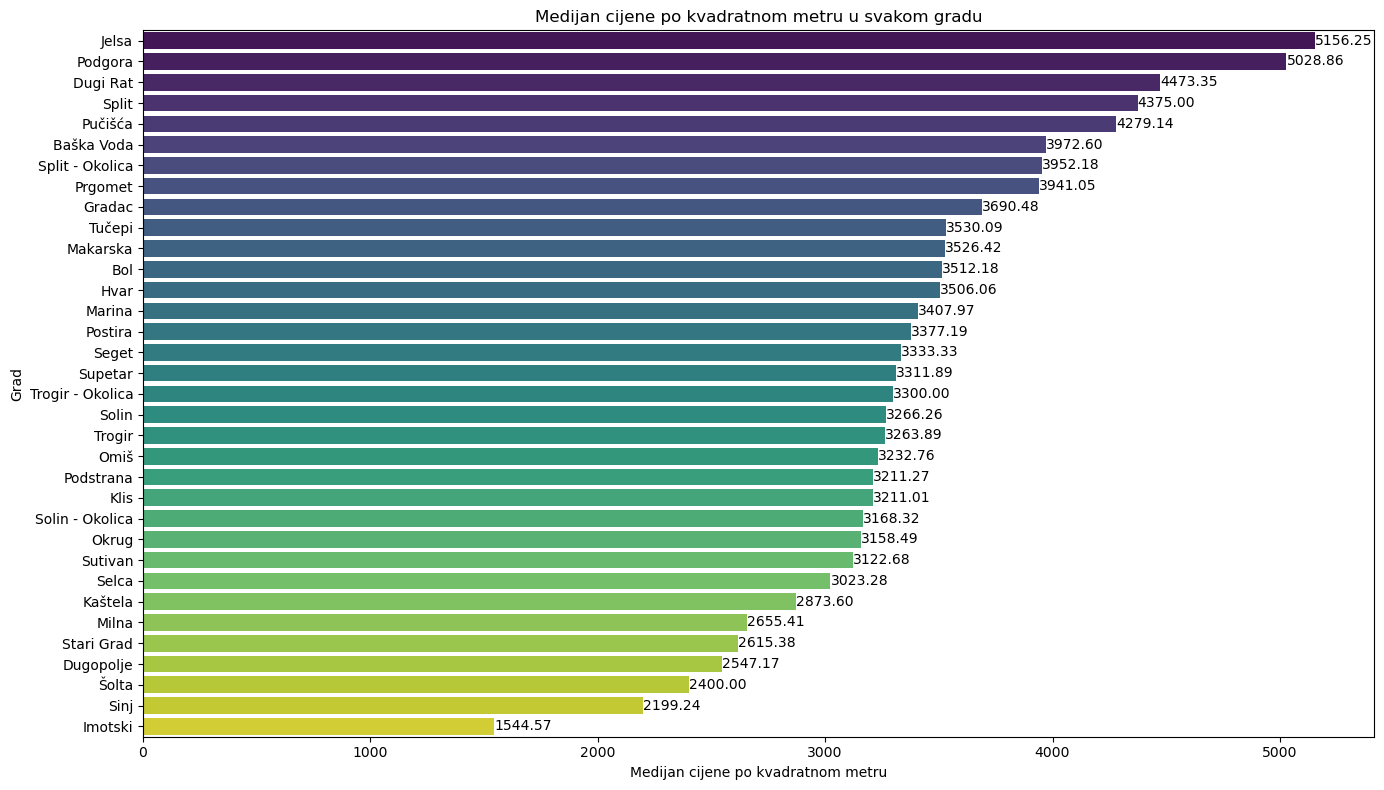

In [201]:
df['Price per sqm'] = df['Price'] / df['Living area']
city_counts = df['City'].value_counts()

valid_cities = city_counts[city_counts >= 3].index
df_filtered = df[df['City'].isin(valid_cities)]

median_price_per_sqm_city = df_filtered.groupby('City')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_city.values, y=median_price_per_sqm_city.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_city.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Grad')
plt.title('Medijan cijene po kvadratnom metru u svakom gradu')
plt.tight_layout()
plt.show()

## 4.Izračunavanje medijana cijene po kvadratnom metru kvartova u gradu Splitu

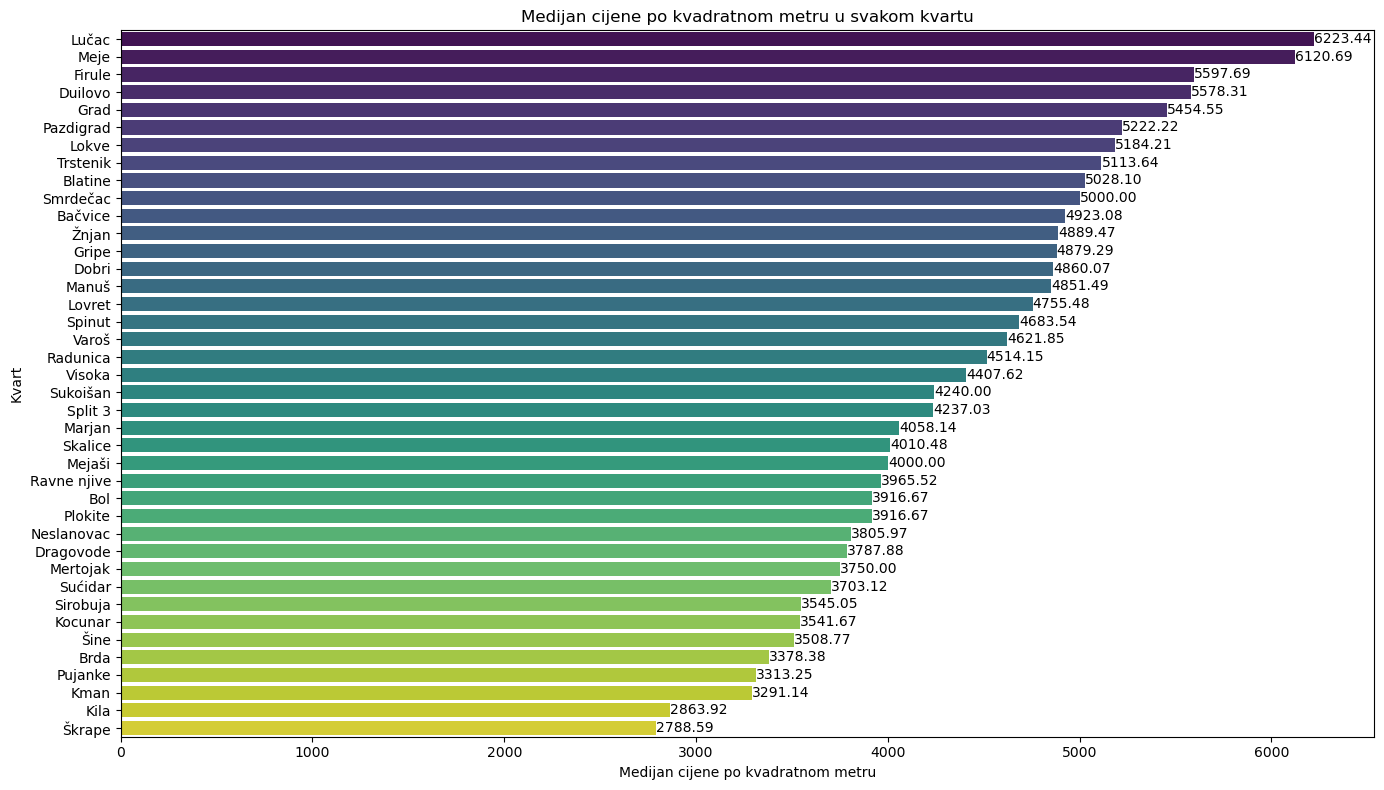

In [202]:
split_data = df[df['City'] == 'Split']
neighborhood_counts = split_data['Neighborhood'].value_counts()

valid_neighborhoods = neighborhood_counts[neighborhood_counts >= 3].index
df_filtered = df[df['Neighborhood'].isin(valid_neighborhoods)]

median_price_per_sqm_neighborhood = df_filtered.groupby('Neighborhood')['Price per sqm'].median().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=median_price_per_sqm_neighborhood.values, y=median_price_per_sqm_neighborhood.index, palette='viridis')
for index, value in enumerate(median_price_per_sqm_neighborhood.values):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', color='black', fontsize=10)
plt.xlabel('Medijan cijene po kvadratnom metru')
plt.ylabel('Kvart')
plt.title('Medijan cijene po kvadratnom metru u svakom kvartu')
plt.tight_layout()
plt.show()

## 5. Pristutnost stanova po etažama u županiji

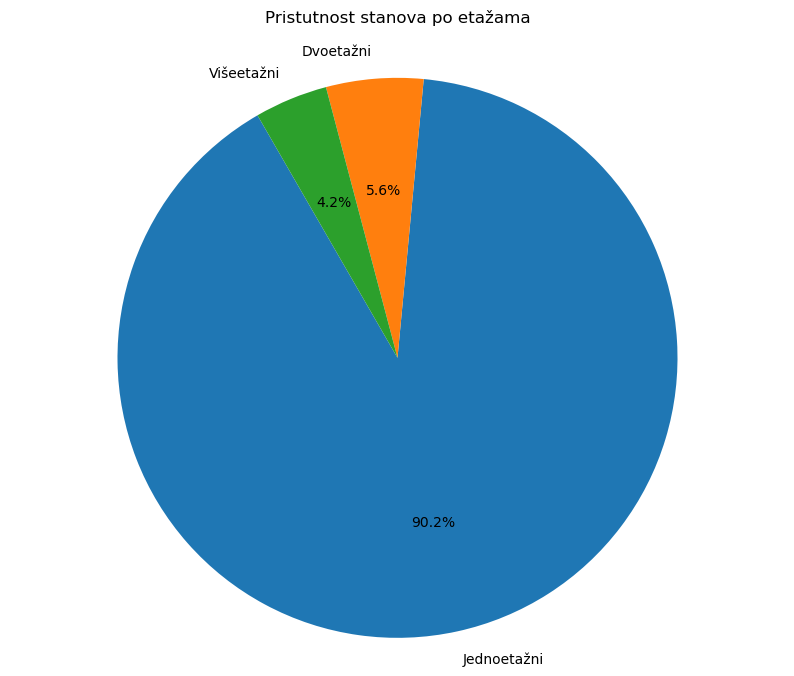

In [203]:
number_of_floors_counts = df['Number of floors'].value_counts()
total_occurrences = number_of_floors_counts.sum()

percentage_occurrences = (number_of_floors_counts / total_occurrences) * 100

plt.figure(figsize=(10, 8))
plt.pie(percentage_occurrences, labels=percentage_occurrences.index, autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=120)
plt.axis('equal')
plt.title('Pristutnost stanova po etažama', pad=20)
plt.show()

## 6. Pristutnost stanova po sobama u županiji

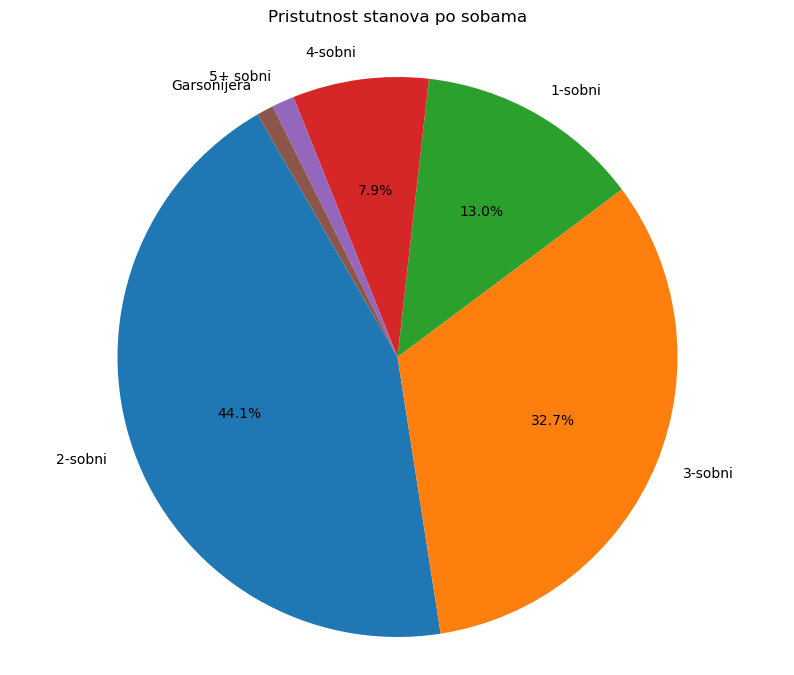

In [204]:
number_of_rooms_counts = df['Number of rooms'].value_counts()
total_occurrences = number_of_rooms_counts.sum()

percentage_occurrences = (number_of_rooms_counts / total_occurrences) * 100

plt.figure(figsize=(10, 8))
plt.pie(percentage_occurrences, labels=percentage_occurrences.index, autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=120)
plt.axis('equal')
plt.title('Pristutnost stanova po sobama', pad=20)
plt.show()

## 7. Omjer stanova u zgradi i kući u županiji

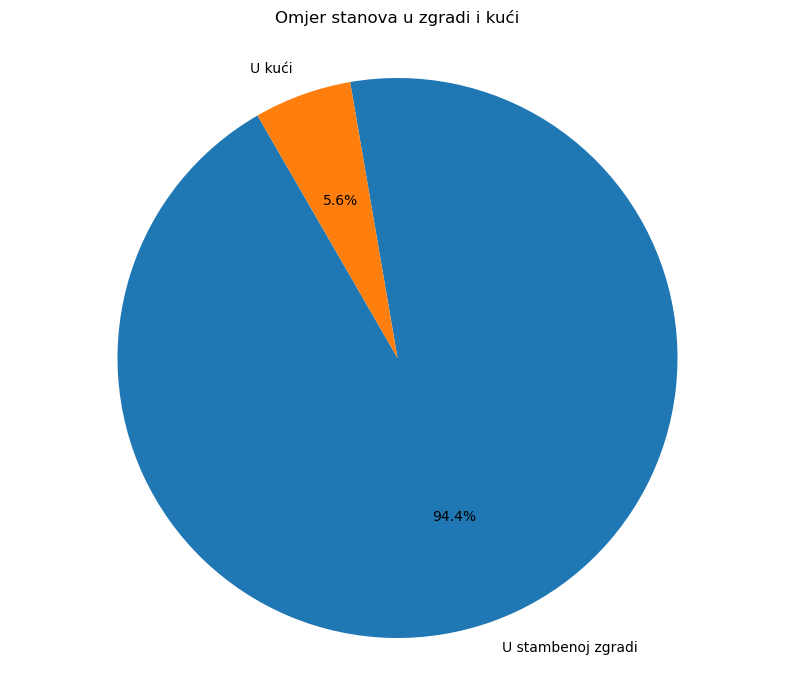

In [205]:
type_of_flat_counts = df['Type of flat'].value_counts()
total_occurrences = type_of_flat_counts.sum()

percentage_occurrences = (type_of_flat_counts / total_occurrences) * 100

plt.figure(figsize=(10, 8))
plt.pie(percentage_occurrences, labels=percentage_occurrences.index, autopct=lambda p: '{:.1f}%'.format(p) if p >= 2 else '', startangle=120)
plt.axis('equal')
plt.title('Omjer stanova u zgradi i kući', pad=20)
plt.show()